In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import numpy as np 
import pickle
import sys
sys.path.append('../')

from src.SlovotvirModel import run_model_parallel
from src.helpers import letter_subplots


sns.set(context='paper', 
        style='ticks', 
        font_scale=1.2,
        rc={'axes.spines.right': False, 
            'axes.spines.top': False,})

/opt/homebrew/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# unpickle data/post_samples_final_0306.pkl
with open('../data/post_samples_final_2012.pkl', 'rb') as f:
    post_samples = pickle.load(f)

In [3]:
# unpickle prior draws
with open('../data/prior_draws.pkl', 'rb') as f:
    prior_draws = pickle.load(f)

In [4]:
true_likes = pickle.load(open("../data/true_likes.pkl", "rb"))
true_likes_lengths = pickle.load(open("../data/true_len_likes.pkl", "rb"))

In [5]:
# divide true_likes_lengths into likes and lengths
# true_likes = [x[1] for x in true_likes_lengths]
true_lengths = [x[0] for x in true_likes_lengths]

In [6]:
priors = [np.random.uniform(-5, 1, 50000), 
          np.random.uniform(-2, 2, 50000),
          np.random.lognormal(0, 0.5, 50000),]

param_names = ['Length bias (α)', 
               'Frequency bias (β)', 
               'Exploration bias (τ)']

post_hdi = az.hdi(post_samples, hdi_prob=0.95)

null = [0, 1, 1]

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_74846/2009658165.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  post_hdi = az.hdi(post_samples, hdi_prob=0.95)


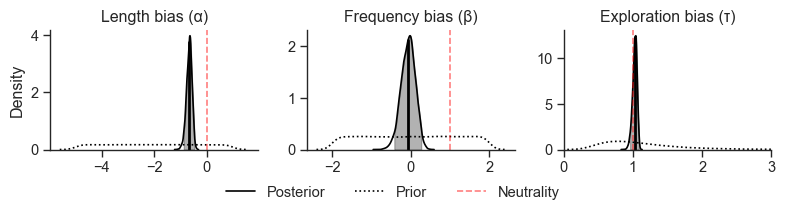

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2))

for i in range(3):
    x_values, y_values = sns.kdeplot(post_samples[:, i], 
                                     ax=ax[i], 
                                     color='black',
                                     common_norm=True,
                                     label='Posterior').lines[0].get_data()
    y_values /= np.trapz(y_values, x_values)
    ax[i].fill_between(x_values, y_values, 
                       where=(x_values >= post_hdi[i][0]) & 
                        (x_values <= post_hdi[i][1]), 
                        color='black', alpha=0.3)
    
    sns.kdeplot(priors[i], ax=ax[i], 
                color='black', 
                linestyle='dotted',
                common_norm=True,
                label='Prior')
    
    # Add mean line for posterior
    posterior_mean = np.mean(post_samples[:, i])
    mean_density = np.interp(posterior_mean, x_values, y_values)
    ax[i].plot([posterior_mean, posterior_mean], [0, mean_density], 
               color='black', linestyle='solid', alpha=1, linewidth=2)

    ax[i].set_title(param_names[i])
    ax[i].axvline(null[i], 
                  color='red', 
                  linestyle='dashed',
                  alpha=0.5,
                  label='Neutrality')
    if i == 0:
        ax[i].set_ylabel('Density')
    elif i == 2:
        ax[i].set_xlim(0, 3)
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('')
    
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, 
           loc='lower center', ncol=3,
           frameon=False, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
# save figure
plt.savefig('../figures/posteriors_final.pdf',
            dpi=300, 
            bbox_inches='tight')
plt.show()

In [8]:
# unpickle posterior predictive samples (posterior_predictive_length and neutral_predictive_length)

with open('../data/posterior_predictive_length.pkl', 'rb') as f:
    posterior_predictive = pickle.load(f)

with open('../data/neutral_predictive_length.pkl', 'rb') as f:
    neutral_ = pickle.load(f)

In [9]:
# posterior_predictive = run_model_parallel(np.random.choice(post_samples[:, 0], 500), 
#                                           np.random.choice(post_samples[:, 1], 500), 
#                                           np.random.choice(post_samples[:, 2], 500), 500)

# # pickle
# with open('../data/posterior_predictive_length.pkl', 'wb') as f:
#     pickle.dump(posterior_predictive, f)

In [10]:
# neutral_ = run_model_parallel([0] * 500, 
#                               np.random.choice(post_samples[:, 1], 500), 
#                               np.random.choice(post_samples[:, 2], 500), 
#                               500)

# # pickle
# with open('../data/neutral_predictive_length.pkl', 'wb') as f:
#     pickle.dump(neutral_, f)

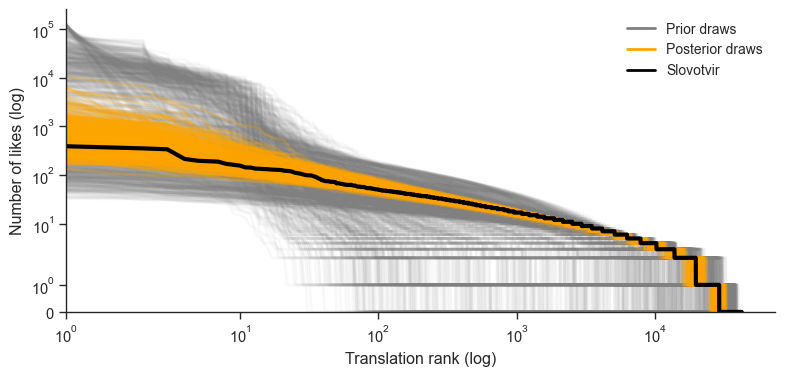

In [11]:
plt.figure(figsize=(8, 4))  # Increased height to fit the plot

# First plot with log x-scale
ax1 = plt.subplot(1, 1, 1)

# Plot prior draws with label
for i, d in enumerate(prior_draws):
    label = 'Prior draws' if i == 0 else None
    ax1.plot(range(1, len(d) + 1), d, 
             color='grey', 
             alpha=0.05, 
             linewidth=2,
             label=label)

# Plot parameter estimates with label
for i, _ in enumerate(posterior_predictive):
    label = 'Posterior draws' if i == 0 else None
    ax1.plot(range(1, len(_[0]) + 1), _[0], 
             color='orange', 
             alpha=0.25, 
             linewidth=2,
             label=label)

ax1.plot(range(1, len(true_likes) + 1), 
         true_likes, 
         label='Slovotvir', 
         color='black', 
         linewidth=3, 
         alpha=1)

ax1.set_xscale('symlog', base=10)
ax1.set_yscale("symlog", base=10)
ax1.set_xlabel('Translation rank (log)')
ax1.set_ylabel('Number of likes (log)')
ax1.set_ylim(0, None)
ax1.set_xlim(1, None)

sns.despine()

# Adjust layout to make room for the legend at the bottom
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

# Create a legend and place it at the bottom
handles, labels = ax1.get_legend_handles_labels()
legend = plt.legend(handles, labels, 
                    frameon=False, 
                    ncol=1,
                    fontsize=10)
for legend_line in legend.get_lines():
    legend_line.set_alpha(1.0)
    legend_line.set_linewidth(2)

plt.show()

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_74846/1044462228.py:82: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.stripplot(data=df,


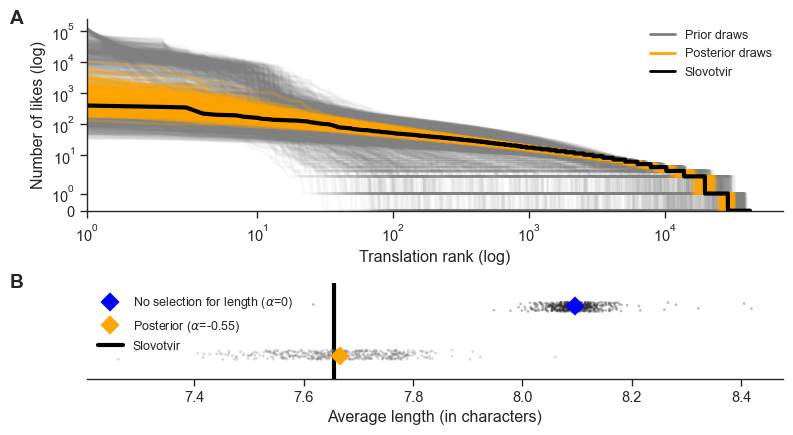

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4.5), gridspec_kw={'height_ratios': [2, 1]})

# apply tufte style
letter_subplots()

# First plot with log x-scale
ax1 = axes[0]

# Plot prior draws with label
for i, d in enumerate(prior_draws):
    label = 'Prior draws' if i == 0 else None
    ax1.plot(range(1, len(d) + 1), d, 
             color='grey', 
             alpha=0.05, 
             linewidth=2,
             label=label)

# Plot parameter estimates with label
for i, _ in enumerate(posterior_predictive):
    label = 'Posterior draws' if i == 0 else None
    ax1.plot(range(1, len(_[0]) + 1), _[0], 
             color='orange', 
             alpha=0.25, 
             linewidth=2,
             label=label)

ax1.plot(range(1, len(true_likes) + 1), 
         true_likes, 
         label='Slovotvir', 
         color='black', 
         linewidth=3, 
         alpha=1)

ax1.set_xscale('symlog', base=10)
ax1.set_yscale("symlog", base=10)
ax1.set_xlabel('Translation rank (log)')
ax1.set_ylabel('Number of likes (log)')
ax1.set_ylim(0, None)
ax1.set_xlim(1, None)
ax1.set_rasterized(True)

sns.despine(ax=ax1)

# Create a legend and place it at the bottom
handles, labels = ax1.get_legend_handles_labels()
legend = ax1.legend(handles, labels, 
                    frameon=False, 
                    ncol=1,
                    fontsize=9)
for legend_line in legend.get_lines():
    legend_line.set_alpha(1.0)
    legend_line.set_linewidth(2)

# Second plot: Histogram
ax2 = axes[1]

# ax2.hist([sum(y) / sum(x) for x, y in neutral_], 
#          bins=20,
#          label='No selection for length (\u03b1=0)', 
#          color='blue', 
#          alpha=1, 
#          density=True,
#          align='left')
# ax2.hist([sum(y) / sum(x) for x, y in posterior_predictive], 
#          bins=20,
#          label='Posterior draws (\u03b1=-0.55)', 
#          color='orange', 
#          alpha=1, 
#          density=True,
#          align='left')

# use swarmplots instead of histograms (you need to create a df first)

# Create a DataFrame with all the data
df = {
    'Length': [sum(y) / sum(x) for x, y in neutral_] + [sum(y) / sum(x) for x, y in posterior_predictive],
    'Group': [r'No selection for length ($\alpha$=0)'] * len(neutral_) + [r'Posterior ($\alpha$=-0.55)'] * len(posterior_predictive)
}

# Create a swarmplot oriented horizontally

sns.stripplot(data=df,
              x='Length',
              y='Group',
              ax=ax2,
              hue='Group',
              alpha=0.3,
              size=2,
              orient='h',
              legend=False, 
              zorder=-10,
              color='grey',
            #   palette=['blue', 'orange']
              )

sns.pointplot(data=df,
              x='Length',
              y='Group',
              ax=ax2,
              hue='Group',
              linestyle='none',
              markersize=8,
              errorbar=None,
              markers='D',
              linestyles='',
              dodge=True,
              zorder=10,
              palette=['blue', 'orange'],
              legend=True)

# remove x ticks
ax2.set_yticks([])

true_avg_length = sum(true_lengths * true_likes) / sum(true_likes)
# add a vertical line for the true average length
ax2.axvline(true_avg_length, 
            color='black', 
            alpha=1, 
            label='Slovotvir',
            linewidth=3,
            zorder=-11)
ax2.set_xlabel('Average length (in characters)')
ax2.set_ylabel('')


ax2.legend(frameon=False, 
           ncol=1, 
           fontsize=9,
           loc='upper left')
sns.despine(ax=ax2)
# remove y axis and ticks
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_visible(False)

# Adjust layout to make everything fit nicely
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

plt.savefig('../figures/posterior_check.pdf',
            dpi=300, 
            bbox_inches='tight')

plt.show()

In [13]:
print(round(np.mean([sum(y) / sum(x) for x, y in posterior_predictive]), 2))

7.67


In [14]:
print(round(true_avg_length, 2))

7.66


In [15]:
print(round(np.mean([sum(y) / sum(x) for x, y in neutral_]), 2))

8.1


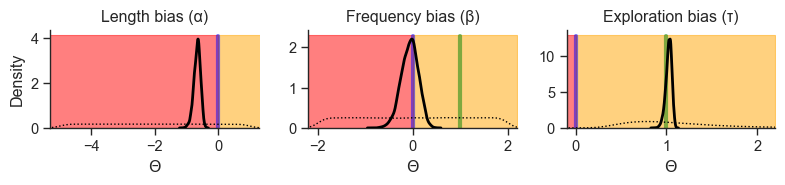

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2))

# apply tufte style to all axes

# only plot frequency bias and exploration bias and not length bias
for i in range(3):

    sns.kdeplot(post_samples[:, i], 
                ax=ax[i], 
                color='black',
                common_norm=True,
                label='Posterior',
                linewidth=2,
                zorder=10)

    sns.kdeplot(priors[i], 
                ax=ax[i], 
                color='black', 
                linestyle='dotted',
                common_norm=True,
                label='Prior',
                linewidth=1,
                zorder=10)
    
    ylim = ax[i].get_ylim()[1]
    
    # ax[i].set_ylabel('')
    
    if i == 0:
        ax[i].set_ylabel('Density')
        ax[i].fill_betweenx([0, ylim], -5.5, 0, color='red', alpha=0.5) 
        ax[i].fill_betweenx([0, ylim], 0, 2.2, color='orange', alpha=0.5)
    else:
        ax[i].fill_betweenx([0, ylim], -2.2, 0, color='red', alpha=0.5) 
        ax[i].fill_betweenx([0, ylim], 0, 2.2, color='orange', alpha=0.5)

    ax[i].axvline(0, color='blue', linewidth=3, ymax=0.94, alpha=0.5)
    if i != 0:
        ax[i].axvline(1, color='green', linewidth=3, ymax=0.94, alpha=0.5)

    ax[i].set_title(param_names[i])

    # set xlabel for every subplot
    ax[i].set_xlabel(r'$\Theta$')

    if i == 1:
        ax[i].set_ylabel('')
        ax[i].set_xlim(-2.2, 2.2)
    elif i == 2:
        ax[i].set_ylabel('')
        ax[i].set_xlim(-0.1, 2.2)
    else:
        ax[i].set_xlim(-5.3, 1.3)

# Uncomment this block if a legend is required:
# handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, 
#            loc='lower center', ncol=3,
#            frameon=False, bbox_to_anchor=(0.5, -0.2))
plt.tight_layout()
plt.savefig('../figures/posteriors_colored.pdf',
            dpi=300, 
            bbox_inches='tight')
plt.show()


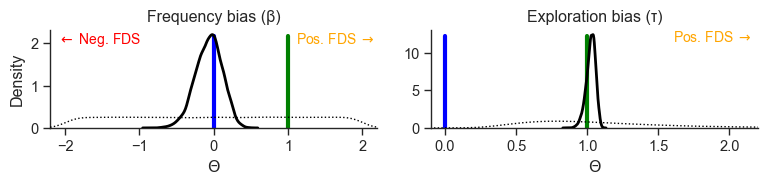

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2))

# # apply tufte style to all axes
# for a in ax:
#     tufte_style(a)

# only plot frequency bias and exploration bias
for i in range(1, 3):
    sns.kdeplot(post_samples[:, i], 
                ax=ax[i-1], 
                color='black',
                common_norm=True,
                label='Posterior',
                linewidth=2,
                zorder=10)

    sns.kdeplot(priors[i], 
                ax=ax[i-1], 
                color='black', 
                linestyle='dotted',
                common_norm=True,
                label='Prior',
                linewidth=1,
                zorder=10)
    
    ylim = ax[i-1].get_ylim()[1]
    
    # ax[i-1].fill_betweenx([0, ylim], -2.2, 0, color='red', alpha=0.5) 
    # ax[i-1].fill_betweenx([0, ylim], 0, 2.2, color='orange', alpha=0.5)

    ax[i-1].axvline(0, color='blue', linewidth=3, ymax=0.94, alpha=1)
    ax[i-1].axvline(1, color='green', linewidth=3, ymax=0.94, alpha=1)

    # add text on the top left corner and top right corner for subplot 1
    if i == 1:
        ax[i-1].text(-2.1, 2, '$\leftarrow$ Neg. FDS', fontsize=10, color='red')
        ax[i-1].text(1.1, 2, 'Pos. FDS $\\rightarrow$', fontsize=10, color='orange')
    else:
        # just positive FDP for subplot 2
        ax[i-1].text(1.6, 11.5, 'Pos. FDS $\\rightarrow$', fontsize=10, color='orange')

    ax[i-1].set_title(param_names[i])

    # set xlabel for every subplot
    ax[i-1].set_xlabel(r'$\Theta$')

    if i == 1:
        ax[i-1].set_ylabel('Density')
        ax[i-1].set_xlim(-2.2, 2.2)
    else:
        ax[i-1].set_ylabel('')
        ax[i-1].set_xlim(-0.1, 2.2)

plt.tight_layout()
plt.savefig('../figures/posteriors_colored_freq.pdf',
            dpi=300, 
            bbox_inches='tight')
plt.show()


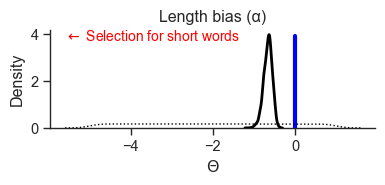

In [23]:
# plot length bias separately
fig, ax = plt.subplots(1, 1, figsize=(4, 2))

# only plot frequency bias and exploration bias
sns.kdeplot(post_samples[:, 0], 
            ax=ax, 
            color='black',
            common_norm=True,
            label='Posterior',
            linewidth=2,
            zorder=10)

sns.kdeplot(priors[0],
            ax=ax, 
            color='black', 
            linestyle='dotted',
            common_norm=True,
            label='Prior',
            linewidth=1,
            zorder=10)

ylim = ax.get_ylim()[1]

# plot vertical line at 0
ax.axvline(0, color='blue', linewidth=3, ymax=0.94, alpha=1, label='Absence of length bias')

# add text on the top left corner and top right corner for subplot 1
ax.text(-5.6, 3.7, '$\leftarrow$ Selection for short words', fontsize=10, color='red')

ax.set_title(param_names[0])

# set xlabel for every subplot
ax.set_xlabel(r'$\Theta$')

ax.set_ylabel('Density')

plt.tight_layout()
plt.savefig('../figures/posteriors_colored_length.pdf',
            dpi=300, 
            bbox_inches='tight')
plt.show()

In [19]:
x = np.arange(0, 100, 1).astype(float)

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_74846/2948678375.py:8: RuntimeWarning: divide by zero encountered in reciprocal
  axs[0].plot(x, x ** -1,


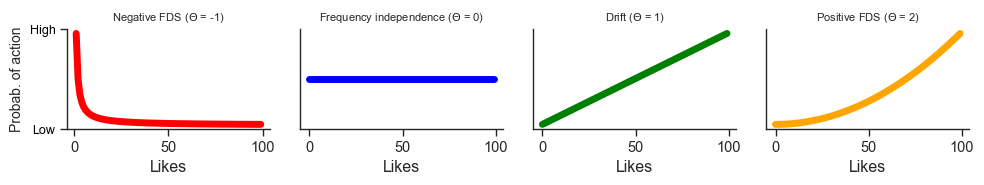

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2))

# # apply tufte style to all axes
# for a in axs:
#     tufte_style(a)

# Plot for β = -1
axs[0].plot(x, x ** -1, 
            linewidth=5, color='red', alpha=1)
axs[0].set_yticks([])
axs[0].set_title(r'Negative FDS ($\Theta$ = -1)', fontsize=8)
axs[0].set_ylabel('Probab. of action', fontsize=10)
axs[0].set_yticks([axs[0].get_ylim()[0], axs[0].get_ylim()[1]])
axs[0].set_yticklabels(['Low', 'High'], fontsize=9, color='black')
axs[0].set_xlabel('Likes')

# Plot for β = 0
axs[1].plot(x, x ** 0, 
            linewidth=5, 
            color='blue', alpha=1)
axs[1].set_yticks([])
axs[1].set_title(r'Frequency independence ($\Theta$ = 0)', fontsize=8)
axs[1].set_ylabel('')
axs[1].set_xlabel('Likes')

# Plot for β = 1
axs[2].plot(x, x ** 1, 
            linewidth=5, 
            color='green', alpha=1)
axs[2].set_yticks([])
axs[2].set_title(r'Drift ($\Theta$ = 1)', fontsize=8)
axs[2].set_ylabel('')
axs[2].set_xlabel('Likes')

# Plot for β = 2
axs[3].plot(x, x ** 2, 
            linewidth=5, color='orange', alpha=1)
axs[3].set_yticks([])
axs[3].set_title(r'Positive FDS ($\Theta$ = 2)', fontsize=8)
axs[3].set_ylabel('')
axs[3].set_xlabel('Likes')

plt.tight_layout()
plt.savefig('../figures/bias_illustration.pdf',
            dpi=300, 
            bbox_inches='tight')
plt.show()
